In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pyod.models.lunar import LUNAR

normal_path = "features/S01/1/Normal/c_data"
relay_path  = "features/S01/1/Relay/c_data"

with h5py.File("datasets/features_S01_combined.h5", "r") as f:
    normal_group = f[normal_path]
    relay_group  = f[relay_path]

    n_norm = normal_group["0"].shape[0]
    n_relay = relay_group["0"].shape[0]

    dataset_normal = np.zeros((49997, n_norm))
    dataset_relay  = np.zeros((49998, n_relay))

    for i in range(49997):
        try:
            dataset_normal[i] = normal_group[str(i)][:]
        except KeyError:
            continue

    for i in range(49998):
        try:
            dataset_relay[i] = relay_group[str(i)][:]
        except KeyError:
            continue

scalerMinMax = MinMaxScaler()
scalerStandard = StandardScaler()

X_train               = dataset_normal[:47500]
X_test_normal         = dataset_normal[47500:]
X_test_relay          = dataset_relay[47500:]

scalerMinMax.fit(X_train)
X_train_scaled_minmax       = scalerMinMax.transform(X_train)
X_test_norm_scaled_minmax   = scalerMinMax.transform(X_test_normal)
X_test_relay_scaled_minmax  = scalerMinMax.transform(X_test_relay)

scalerStandard.fit(X_train)
X_train_scaled_standard        = scalerStandard.transform(X_train)
X_test_norm_scaled_standard    = scalerStandard.transform(X_test_normal)
X_test_relay_scaled_standard   = scalerStandard.transform(X_test_relay)

X_test_combined = np.vstack((X_test_normal, X_test_relay))
X_test_combined_scaled_minmax = np.vstack((X_test_norm_scaled_minmax, X_test_relay_scaled_minmax))
X_test_combined_scaled_standard = np.vstack((X_test_norm_scaled_standard, X_test_relay_scaled_standard))

y_true = np.array([0] * len(X_test_normal) + [1] * len(X_test_relay))

neighbors 1

Classification Report:
               precision    recall  f1-score   support

      Normal       0.60      0.90      0.72      2497
       Relay       0.80      0.41      0.54      2498

    accuracy                           0.65      4995
   macro avg       0.70      0.65      0.63      4995
weighted avg       0.70      0.65      0.63      4995



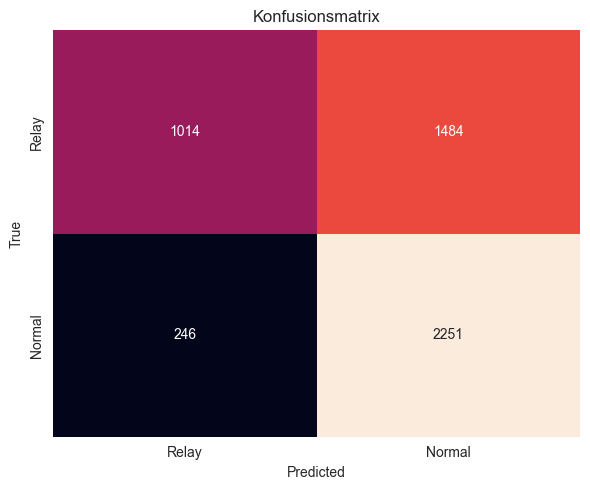

KeyboardInterrupt: 

In [2]:
for n in {1,3,5,10}:
    clf = LUNAR(contamination=0.01, n_neighbours=n, scaler=None)
    clf.fit(X_train)

    # pyod.predict: 0 = inlier, 1 = outlier
    y_pred = clf.predict(X_test_combined)

    # cm und report
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    print(f"neighbors {n}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

    # plot
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=["Relay","Normal"],
                yticklabels=["Relay","Normal"],
                cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Konfusionsmatrix")
    plt.tight_layout()
    plt.show()

neighbors 1

Classification Report:
               precision    recall  f1-score   support

      Normal       0.71      0.90      0.79      2497
       Relay       0.86      0.63      0.73      2498

    accuracy                           0.77      4995
   macro avg       0.79      0.77      0.76      4995
weighted avg       0.79      0.77      0.76      4995



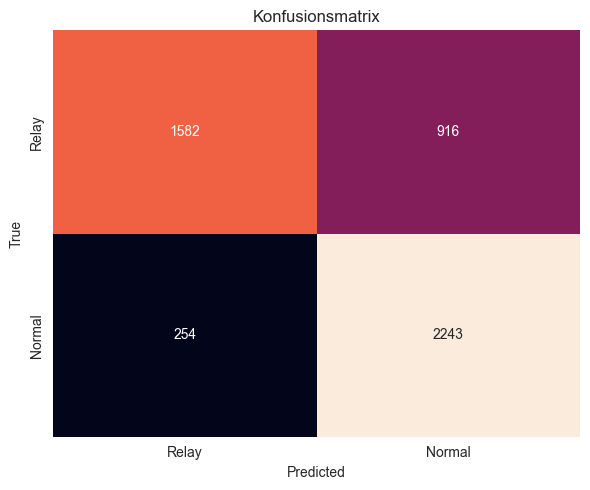

KeyboardInterrupt: 

In [18]:
for n in {1,3,5,10}:
    clf = LUNAR(contamination=0.01, n_neighbours=n, scaler=None)
    clf.fit(X_train_scaled_standard)

    # pyod.predict: 0 = inlier, 1 = outlier
    y_pred = clf.predict(X_test_combined_scaled_standard)

    # cm und report
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    print(f"neighbors {n}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

    # plot
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=["Relay","Normal"],
                yticklabels=["Relay","Normal"],
                cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Konfusionsmatrix")
    plt.tight_layout()
    plt.show()

In [ ]:
for n in {1,3,5,10}:
    clf = LUNAR(contamination=0.01, n_neighbours=n, scaler=None)
    clf.fit(X_train_scaled_minmax)

    # pyod.predict: 0 = inlier, 1 = outlier
    y_pred = clf.predict(X_test_combined_scaled_minmax)

    # cm und report
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    print(f"neighbors {n}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

    # plot
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=["Relay","Normal"],
                yticklabels=["Relay","Normal"],
                cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Konfusionsmatrix")
    plt.tight_layout()
    plt.show()

In [2]:
param_grid = [{
    # Zwei Scoring-Architekturen
    "model_type": ["WEIGHT", "SCORE"],
    # Nach Nutzer bereits für n_neighbors=1 gute Ergebnisse gesehen
    "n_neighbours": [1],
    # Art der Negativ-Proben
    "negative_sampling": ["UNIFORM", "SUBSPACE", "MIXED"],
    # Validierungs-Split-Größe
    "val_size": [0.05, 0.07],
    # Skalierer
    "epsilon": [0.05, 0.1, 0.2],
    # Verhältnis negativer Beispiele
    "proportion": [0.5, 1.0, 2.0],
    # Lernrate
    "lr": [1e-3, 1e-4],
    # Weight-Decays
    "wd": [0.01, 0.05],
    # Anteil der Ausreißer im Datensatz
    "contamination": [0.1],
    #Scaler
    "scaler": [None]
}]

best_acc = 0
best_params = None

for params in ParameterGrid(param_grid[0]):
    clf = LUNAR(**params)
    clf.fit(X_train_scaled_standard)

    y_pred = clf.predict(X_test_combined_scaled_standard)

    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}  → Params: {params}")

    if acc > best_acc:
        best_acc = acc
        best_params = params

print("\nBeste Parameterkombination:", best_params)
print(f"Beste Accuracy: {best_acc:.4f}")


KeyboardInterrupt: 